<center> 

# **Cough sound analysis using Deep Learning methods for COVID-19 diagnosis**

### Division of Information Transmission Systems and Material Technology

## Christina Ntourma
</center>

#Imports

In [ ]:
import matplotlib
import numpy as np
import csv
import json
import os
import sys
import pickle
import time
from google.colab import files


#for loading and visualizing audio files
import librosa
import librosa.display
import pywt
import statistics
import warnings
from os import listdir
from os.path import isfile, join
import random
import pandas as pd
import subprocess
from pathlib import Path
from matplotlib import pyplot as plt
from math import sqrt

In [ ]:
import tensorflow as tf

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_curve, roc_auc_score, confusion_matrix

print(tf.__version__)

2.6.0


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# 1st training of the model with Cough Heavy Coswara dataset

## Initialize Training for 1st training with Cough Heavy Coswara dataset

In [ ]:
transform_name = 'hcqt_cough-heavy'
dataset = 'Coswara_cough-heavy'
batch_size = 32

## Prepare data

In [ ]:
csv_path = 'Coswara_labels_cough-heavy.csv' # path to labels csv

labels_dict = {}
with open(csv_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      if row[1] == 'neg':
        labels_dict[row[0]] = [0.0]
      elif row[1] == 'pos':
        labels_dict[row[0]] = [1.0]

In [ ]:
image_path = "Coswara/Coswara/" + transform_name + "/" # path to images

input_arr = []
labels_arr = []
for i in os.listdir(image_path):
  if i in labels_dict.keys():
    image = tf.keras.preprocessing.image.load_img(image_path + i, color_mode = 'rgb', target_size = (32,32,3))
    labels_arr.append(labels_dict[i])
    input_arr.append(tf.keras.preprocessing.image.img_to_array(image))

In [ ]:
input_arr = np.array(input_arr)
labels_arr = np.array(labels_arr)

print(input_arr.shape)
print(labels_arr.shape)

(1541, 32, 32, 3)
(1541, 1)


In [ ]:
tmp = list(zip(input_arr, labels_arr))

random.Random(0).shuffle(tmp)

input_arr, labels_arr = zip(*tmp)
input_arr = np.array(input_arr)
labels_arr = np.array(labels_arr)

In [ ]:
data_size, img_rows, img_cols, img_channels = input_arr.shape

In [ ]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 32
IMG_SHAPE = (img_rows, img_cols, img_channels)
threshold = 0.5
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

## Model architecture

In [ ]:
def init_model(summary, IMG_SHAPE):
  resnet_model=tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
  
  RESNET_MODEL=resnet_model.layers[0](resnet_model)

  RESNET_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')

  model = tf.keras.Sequential([RESNET_MODEL, dropout_layer, global_average_layer, prediction_layer])
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.4) , 
                metrics=[tf.keras.metrics.Recall(name='Recall', thresholds = threshold),
                         tf.keras.metrics.Precision(name='Precision', thresholds = threshold), 
                         tf.keras.metrics.AUC(name='AUC'), 
                         tf.keras.metrics.BinaryAccuracy(name='Accuracy', threshold= threshold),
                         tf.keras.metrics.TruePositives(thresholds = threshold),
                         tf.keras.metrics.FalsePositives(thresholds = threshold),
                         tf.keras.metrics.FalseNegatives(thresholds = threshold),
                         tf.keras.metrics.TrueNegatives(thresholds = threshold)])
  if summary: 
    model.summary()
  return model

## Train-test-validation split

In [ ]:
train_percentage = 0.80
val_percentage = 0.20

val_size = round(val_percentage*data_size)

# Reserve val_size samples for validation and normalize all values
x_val = input_arr[-val_size:]/255
y_val = labels_arr[-val_size:]
x_train = input_arr[:-val_size]/255
y_train = labels_arr[:-val_size]

## Functions used during training and testing

In [ ]:
def evaluate_trained_model(x_test, y_test, new_model, steps_per_epoch = 10):
    loss, recall, precision, auc, acc, tp, fp, fn, tn = new_model.evaluate(x_test, y_test, steps = steps_per_epoch)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print('Restored model, recall: {:5.2f}%'.format(100 * recall))
    print('Restored model, precision: {:5.2f}%'.format(100 * precision))
    print('Restored model, AUC: {:5.2f}%'.format(100 * auc))

    print('Restored model, true positives: ', tp)
    print('Restored model, false positives: ', fp)
    print('Restored model, false negatives: ', fn)
    print('Restored model, true negatives: ', tn)
    return recall, precision, auc, acc, tp, fp, fn, tn

In [ ]:
def get_predictions(model, x_test, y_test, threshold, steps_per_epoch):
    pred=model.predict(x_test, steps = steps_per_epoch)
    
    probabilities = []
    predictions = []
    for i in pred:
        if i[0] >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
    for i in pred:
        probabilities.append(i[0])
    
    return probabilities, predictions, pred

In [ ]:
# Plot ROC curve

def plot_roc(y_true, probabilities):
    y_true_int = []
    for i in y_true:
        y_true_int.append(int(i))

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_true_int, probabilities)
    # plot the roc curve for the model
    plt.subplot(526)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='CNN Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    print(roc_auc_score(y_true_int, probabilities), "AUC")
    return tpr, fpr, thresholds

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  plt.figure(figsize=(15, 15))
  plt.suptitle('Training Curves')
  # plot loss
  
  plt.subplot(521)
  plt.title('Binary Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
  plt.legend(loc='upper right')
  # plot accuracy
  plt.subplot(522)
  plt.title('Classification Accuracy')
  plt.plot(history.history['Accuracy'], color='blue', label='train')
  plt.plot(history.history['val_Accuracy'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(523)
  plt.title('Classification Recall')
  plt.plot(history.history['Recall'], color='blue', label='train')
  plt.plot(history.history['val_Recall'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(524)
  plt.title('Classification Precision')
  plt.plot(history.history['Precision'], color='blue', label='train')
  plt.plot(history.history['val_Precision'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(525)
  plt.title('Classification AUC')
  plt.plot(history.history['AUC'], color='blue', label='train')
  plt.plot(history.history['val_AUC'], color='orange', label='val')
  plt.legend(loc='lower right')
  return plt

In [ ]:
def calculate_weights(y_train):
    no_neg = 0
    no_pos = 0
    for i in y_train:
        if i[0] == 0.0:
            no_neg = no_neg + 1
        else:
            no_pos = no_pos + 1
    print("Number of negatives", no_neg, "Number of positives", no_pos)

    ratio = (no_pos*100)/(no_neg+no_pos)
    w_0 = ratio
    w_1 = 100-ratio
    print("w_0:", w_0)
    print("w_1:", w_1)

    # Give class weights
    class_weight = {0: w_0,
                    1: w_1}
    return class_weight

In [ ]:
def _input_fn(x, y, BATCH_SIZE, data_size, IMG_SIZE): ### to data size prostethike meta

  x_reshaped = []
  print(x.shape)
  for i in x:
    x_reshaped.append(tf.image.resize(i, IMG_SIZE))
  x_reshaped = np.array(x_reshaped)
  print(x_reshaped.shape)
  ds = tf.data.Dataset.from_tensor_slices((x_reshaped,y)) 
  ds = ds.shuffle(buffer_size=data_size) # https://datascience.stackexchange.com/questions/89316/tensorflows-shufflebuffer-size
  ds = ds.repeat() # https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
def train_model(model, train_ds, validation_ds, weights, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps, class_weight = weights)
  return(history)

In [ ]:
def train_1st_model(x_train, y_train, x_val, y_val):
  img = 100

  IMG_SHAPE = (img, img, 3)
  validation_ds =_input_fn(x_val,y_val, BATCH_SIZE, data_size, (img,img)) 

  neg = 0 
  pos = 0
  for i in y_train:

    if i[0] == 1.0:
      pos = pos + 1
    elif i[0] == 0.0:
      neg = neg + 1

  sm = SMOTE(random_state=42)
  (d_x, r_x, c_x, ch_x) = x_train.shape
  train_x = np.reshape(x_train, (d_x,r_x*c_x*ch_x))
  
  X_smote, y_smote = sm.fit_resample(train_x, y_train)
  print(train_x.shape)
  print(X_smote.shape)

  ## change labels format to match the format used by the rest of the functions
  new_y_smote = []
  for i in y_smote:
      new_y_smote.append([i])
  new_y_smote = np.array(new_y_smote)

  new_size, _ =  X_smote.shape
  smote_x = np.reshape(X_smote, (new_size,r_x,c_x,ch_x))
  weights = calculate_weights(new_y_smote)

  print("TRAIN SET", "Negative:", neg, "Positive:", pos, "Total:", neg+pos) 

  val_steps = len(y_val)/BATCH_SIZE
  train_ds =_input_fn(smote_x ,new_y_smote, BATCH_SIZE, data_size, (img,img)) 
  model = init_model(True, IMG_SHAPE)

  model_history = train_model(model, train_ds, validation_ds, weights, 20, int(len(y_train)/BATCH_SIZE), val_steps)
  
  summarize_diagnostics(model_history)
  
  print()
  print("-------------------------------------------------------------------------------------------------------------------------------------------")
  print("-------------------------------------------------------------------------------------------------------------------------------------------")
  return model

## Train and test model

(308, 32, 32, 3)
(308, 100, 100, 3)
(1233, 3072)
(2306, 3072)
Number of negatives 1153 Number of positives 1153
w_0: 50.0
w_1: 50.0
TRAIN SET Negative: 1153 Positive: 80 Total: 1233
(2306, 32, 32, 3)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(2306, 100, 100, 3)
94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
38/38 [==============================] - 51s 309ms/step - loss: 31.4015 - Recall: 0.8121 - Precision: 0.8435 - AUC: 0.9080 - Accuracy: 0.8429

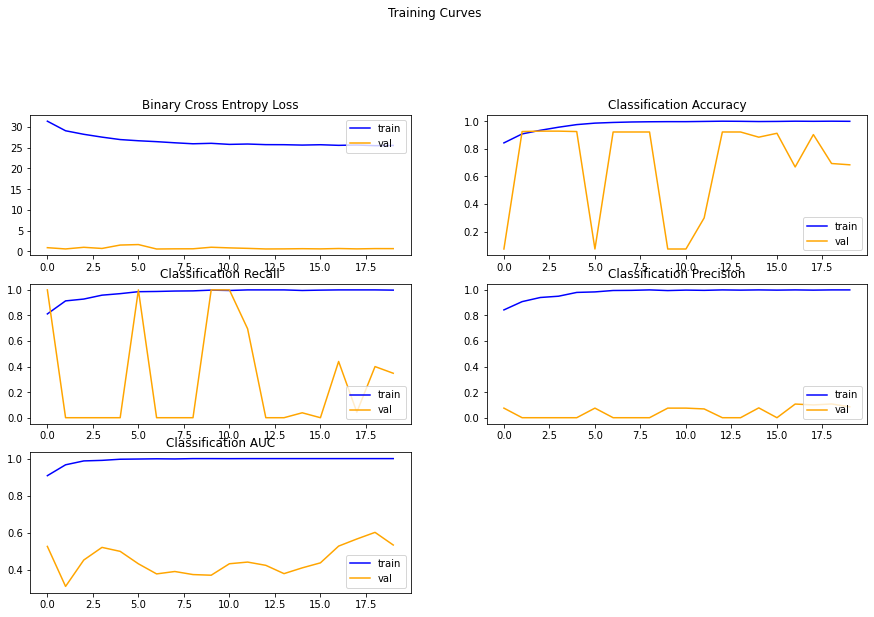

In [ ]:
threshold = 0.5
new_model = train_1st_model(x_train, y_train, x_val, y_val)

## Save and download model

In [ ]:
tf.keras.models.save_model(new_model, "/content/model")

INFO:tensorflow:Assets written to: /content/model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
!zip -r /content/hcqt_heavy.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model/variables/variables.index (deflated 80%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 92%)
  adding: content/model/keras_metadata.pb (deflated 96%)


# 1st training of the model with Cough Shallow Coswara dataset

## Initialize Training for 1st training with Cough Shallow dataset

In [ ]:
transform_name = 'hcqt_cough-shallow'
dataset = 'Coswara_cough-shallow' # 'Coswara_full', 'Coswara_cough-heavy', 'Coswara_cough-shallow', 'EPFL', 'EPFL_small'
batch_size = 32

In [ ]:
!unzip "/content/hcqt_heavy.zip" 

Archive:  /content/hcqt_heavy.zip
   creating: content/model/
   creating: content/model/variables/
  inflating: content/model/variables/variables.data-00000-of-00001  
  inflating: content/model/variables/variables.index  
   creating: content/model/assets/
  inflating: content/model/saved_model.pb  
  inflating: content/model/keras_metadata.pb  


## Prepare data

In [ ]:
csv_path = 'Coswara_labels_cough-shallow.csv' # path to labels csv

labels_dict = {}
with open(csv_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      if row[1] == 'neg':
        labels_dict[row[0]] = [0.0]
      elif row[1] == 'pos':
        labels_dict[row[0]] = [1.0]

In [ ]:
image_path = "Coswara/Coswara/" + transform_name + "/" # path to folder containing images

input_arr = []
labels_arr = []
for i in os.listdir(image_path):
  if i in labels_dict.keys():
    image = tf.keras.preprocessing.image.load_img(image_path + i, color_mode = 'rgb', target_size = (32,32,3))
    labels_arr.append(labels_dict[i])
    input_arr.append(tf.keras.preprocessing.image.img_to_array(image))

In [ ]:
input_arr = np.array(input_arr)
labels_arr = np.array(labels_arr)

print(input_arr.shape)
print(labels_arr.shape)

(1539, 32, 32, 3)
(1539, 1)


In [ ]:
tmp = list(zip(input_arr, labels_arr))

random.Random(0).shuffle(tmp)

input_arr, labels_arr = zip(*tmp)
input_arr = np.array(input_arr)
labels_arr = np.array(labels_arr)

In [ ]:
data_size, img_rows, img_cols, img_channels = input_arr.shape

In [ ]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 32
IMG_SHAPE = (img_rows, img_cols, img_channels)
threshold = 0.5
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

## Train-test-validation split

In [ ]:
train_percentage = 0.80
val_percentage = 0.20

val_size = round(val_percentage*data_size)

# Reserve val_size samples for validation and normalize all values
x_val = input_arr[-val_size:]/255
y_val = labels_arr[-val_size:]
x_train = input_arr[:-val_size]/255
y_train = labels_arr[:-val_size]

## Functions used during training and testing

In [ ]:
def evaluate_trained_model(x_test, y_test, new_model, steps_per_epoch = 10):
    loss, recall, precision, auc, acc, tp, fp, fn, tn = new_model.evaluate(x_test, y_test, steps = steps_per_epoch)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print('Restored model, recall: {:5.2f}%'.format(100 * recall))
    print('Restored model, precision: {:5.2f}%'.format(100 * precision))
    print('Restored model, AUC: {:5.2f}%'.format(100 * auc))

    print('Restored model, true positives: ', tp)
    print('Restored model, false positives: ', fp)
    print('Restored model, false negatives: ', fn)
    print('Restored model, true negatives: ', tn)
    return recall, precision, auc, acc, tp, fp, fn, tn

In [ ]:
def get_predictions(model, x_test, y_test, threshold, steps_per_epoch):
    pred=model.predict(x_test, steps = steps_per_epoch)
    
    probabilities = []
    predictions = []
    for i in pred:
        if i[0] >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
    for i in pred:
        probabilities.append(i[0])
    
    return probabilities, predictions, pred

In [ ]:
# Plot ROC curve

def plot_roc(y_true, probabilities):
    y_true_int = []
    for i in y_true:
        y_true_int.append(int(i))

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_true_int, probabilities)
    # plot the roc curve for the model
    plt.subplot(526)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='CNN Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    print(roc_auc_score(y_true_int, probabilities), "AUC")
    return tpr, fpr, thresholds

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  plt.figure(figsize=(15, 15))
  plt.suptitle('Training Curves')
  # plot loss
  
  plt.subplot(521)
  plt.title('Binary Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
  plt.legend(loc='upper right')
  # plot accuracy
  plt.subplot(522)
  plt.title('Classification Accuracy')
  plt.plot(history.history['Accuracy'], color='blue', label='train')
  plt.plot(history.history['val_Accuracy'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(523)
  plt.title('Classification Recall')
  plt.plot(history.history['Recall'], color='blue', label='train')
  plt.plot(history.history['val_Recall'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(524)
  plt.title('Classification Precision')
  plt.plot(history.history['Precision'], color='blue', label='train')
  plt.plot(history.history['val_Precision'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(525)
  plt.title('Classification AUC')
  plt.plot(history.history['AUC'], color='blue', label='train')
  plt.plot(history.history['val_AUC'], color='orange', label='val')
  plt.legend(loc='lower right')
  return plt

In [ ]:
def calculate_weights(y_train):
    no_neg = 0
    no_pos = 0
    for i in y_train:
        if i[0] == 0.0:
            no_neg = no_neg + 1
        else:
            no_pos = no_pos + 1
    print(no_neg, no_pos, "no_neg, no_pos")

    ratio = (no_pos*100)/(no_neg+no_pos)
    w_0 = ratio
    w_1 = 100-ratio
    print("w_0:", w_0)
    print("w_1:", w_1)

    # Give class weights
    class_weight = {0: w_0,
                    1: w_1}
    return class_weight

In [ ]:
def _input_fn(x, y, BATCH_SIZE, data_size, IMG_SIZE): ### to data size prostethike meta

  x_reshaped = []
  print(x.shape)
  for i in x:
    x_reshaped.append(tf.image.resize(i, IMG_SIZE))
  x_reshaped = np.array(x_reshaped)
  print(x_reshaped.shape)
  ds = tf.data.Dataset.from_tensor_slices((x_reshaped,y)) 
  ds = ds.shuffle(buffer_size=data_size) # https://datascience.stackexchange.com/questions/89316/tensorflows-shufflebuffer-size
  ds = ds.repeat() # https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
def train_model(model, train_ds, validation_ds, weights, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps, class_weight = weights)
  return(history)

In [ ]:
def train_1st_model(x_train, y_train, x_val, y_val):
  img = 100

  IMG_SHAPE = (img, img, 3)
  validation_ds =_input_fn(x_val,y_val, BATCH_SIZE, data_size, (img,img)) 

  neg = 0 
  pos = 0
  for i in y_train:

    if i[0] == 1.0:
      pos = pos + 1
    elif i[0] == 0.0:
      neg = neg + 1

  sm = SMOTE(random_state=42)
  (d_x, r_x, c_x, ch_x) = x_train.shape
  train_x = np.reshape(x_train, (d_x,r_x*c_x*ch_x))
  
  X_smote, y_smote = sm.fit_resample(train_x, y_train)
  print(train_x.shape)
  print(X_smote.shape)

  ## change labels format to match the format used by the rest of the functions
  new_y_smote = []
  for i in y_smote:
      new_y_smote.append([i])
  new_y_smote = np.array(new_y_smote)

  new_size, _ =  X_smote.shape
  smote_x = np.reshape(X_smote, (new_size,r_x,c_x,ch_x))
  weights = calculate_weights(new_y_smote)
  print("TRAIN SET", "Negative:", neg, "Positive:", pos, "Total:", neg+pos) 

  val_steps = len(y_val)/BATCH_SIZE
  train_ds =_input_fn(smote_x ,new_y_smote, BATCH_SIZE, data_size, (img,img)) 

  new_model = keras.models.load_model('content/model') # path to saved model
  new_model.summary()
  model_history = train_model(new_model, train_ds, validation_ds, weights, 20, int(len(y_train)/BATCH_SIZE), val_steps)
  
  summarize_diagnostics(model_history)
  print()
  print("-------------------------------------------------------------------------------------------------------------------------------------------")
  print("-------------------------------------------------------------------------------------------------------------------------------------------")
  return new_model

## Train and test model

(308, 32, 32, 3)
(308, 100, 100, 3)
(1231, 3072)
(2302, 3072)
1151 1151 no_neg, no_pos
w_0: 50.0
w_1: 50.0
TRAIN SET Negative: 1151 Positive: 80 Total: 1231
(2302, 32, 32, 3)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(2302, 100, 100, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
38/38 [==============================] - 20s 306ms/step - loss: 28.2662 - Recall: 0.8608 - Precision: 0.9520 - AUC: 0.9558 - Accuracy: 0.9169 - true_positives: 476.0000 - false_positives: 24.0000 - false_ne

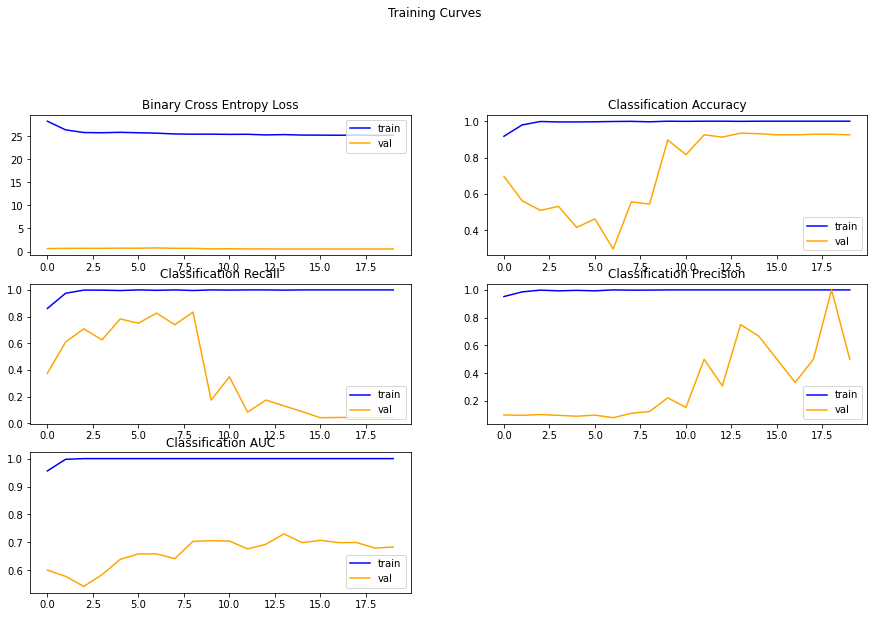

In [ ]:
threshold = 0.5
new_model_1 = train_1st_model(x_train, y_train, x_val, y_val)

## Save and download model

In [ ]:
tf.keras.models.save_model(new_model_1, "/content/model1")

INFO:tensorflow:Assets written to: /content/model1/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
!zip -r /content/hcqt_heavy_shallow.zip /content/model1

  adding: content/model1/ (stored 0%)
  adding: content/model1/variables/ (stored 0%)
  adding: content/model1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model1/variables/variables.index (deflated 80%)
  adding: content/model1/assets/ (stored 0%)
  adding: content/model1/saved_model.pb (deflated 92%)
  adding: content/model1/keras_metadata.pb (deflated 96%)


# 1st training of the model with annotated COUGHVID dataset

In [ ]:
!unzip "/content/hcqt_heavy_shallow.zip" -d "model_6"

Archive:  /content/hcqt_heavy_shallow.zip
   creating: model_6/content/model1/
   creating: model_6/content/model1/variables/
  inflating: model_6/content/model1/variables/variables.data-00000-of-00001  
  inflating: model_6/content/model1/variables/variables.index  
   creating: model_6/content/model1/assets/
  inflating: model_6/content/model1/saved_model.pb  
  inflating: model_6/content/model1/keras_metadata.pb  


In [ ]:
%cd ../../content

/content


## Initialize Training for 1st training with annotated COUGHVID dataset

In [ ]:
transform_name = 'hcqt_small'
dataset = 'EPFL_small' # 'Coswara_full', 'Coswara_cough-heavy', 'Coswara_cough-shallow', 'EPFL', 'EPFL_small'
batch_size = 32

## Prepare data

In [ ]:
csv_path = 'EPFL_small_labels.csv' # path to labels csv

labels_dict = {}
with open(csv_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      if row[1] == 'neg':
        labels_dict[row[0]] = [0.0]
      elif row[1] == 'pos':
        labels_dict[row[0]] = [1.0]

In [ ]:
image_path = "EPFL/EPFL/" + transform_name + "/" # path to folder containing images

input_arr = []
labels_arr = []
for i in os.listdir(image_path):
  if i in labels_dict.keys():
    image = tf.keras.preprocessing.image.load_img(image_path + i, color_mode = 'rgb', target_size = (32,32,3))
    labels_arr.append(labels_dict[i])
    input_arr.append(tf.keras.preprocessing.image.img_to_array(image))

In [ ]:
input_arr = np.array(input_arr)
labels_arr = np.array(labels_arr)

print(input_arr.shape)
print(labels_arr.shape)

(2804, 32, 32, 3)
(2804, 1)


In [ ]:
tmp = list(zip(input_arr, labels_arr))

random.Random(0).shuffle(tmp)

input_arr, labels_arr = zip(*tmp)
input_arr = np.array(input_arr)
labels_arr = np.array(labels_arr)

In [ ]:
data_size, img_rows, img_cols, img_channels = input_arr.shape

In [ ]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 32
IMG_SHAPE = (img_rows, img_cols, img_channels)
threshold = 0.5
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

## Train-test-validation split

In [ ]:
train_percentage = 0.80
val_percentage = 0.20

val_size = round(val_percentage*data_size)

# Reserve val_size samples for validation and normalize all values
x_val = input_arr[-val_size:]/255
y_val = labels_arr[-val_size:]
x_train = input_arr[:-val_size]/255
y_train = labels_arr[:-val_size]

## Functions used during training and testing

In [ ]:
def evaluate_trained_model(x_test, y_test, new_model, steps_per_epoch = 10):
    loss, recall, precision, auc, acc, tp, fp, fn, tn = new_model.evaluate(x_test, y_test, steps = steps_per_epoch)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print('Restored model, recall: {:5.2f}%'.format(100 * recall))
    print('Restored model, precision: {:5.2f}%'.format(100 * precision))
    print('Restored model, AUC: {:5.2f}%'.format(100 * auc))

    print('Restored model, true positives: ', tp)
    print('Restored model, false positives: ', fp)
    print('Restored model, false negatives: ', fn)
    print('Restored model, true negatives: ', tn)
    return recall, precision, auc, acc, tp, fp, fn, tn

In [ ]:
def get_predictions(model, x_test, y_test, threshold, steps_per_epoch):
    pred=model.predict(x_test, steps = steps_per_epoch)
    
    probabilities = []
    predictions = []
    for i in pred:
        if i[0] >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
    for i in pred:
        probabilities.append(i[0])
    
    return probabilities, predictions, pred

In [ ]:
# Plot ROC curve

def plot_roc(y_true, probabilities):
    y_true_int = []
    for i in y_true:
        y_true_int.append(int(i))

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_true_int, probabilities)
    # plot the roc curve for the model
    plt.subplot(526)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='CNN Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    print(roc_auc_score(y_true_int, probabilities), "AUC")
    return tpr, fpr, thresholds

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  plt.figure(figsize=(15, 15))
  plt.suptitle('Training Curves')
  # plot loss
  
  plt.subplot(521)
  plt.title('Binary Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
  plt.legend(loc='upper right')
  # plot accuracy
  plt.subplot(522)
  plt.title('Classification Accuracy')
  plt.plot(history.history['Accuracy'], color='blue', label='train')
  plt.plot(history.history['val_Accuracy'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(523)
  plt.title('Classification Recall')
  plt.plot(history.history['Recall'], color='blue', label='train')
  plt.plot(history.history['val_Recall'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(524)
  plt.title('Classification Precision')
  plt.plot(history.history['Precision'], color='blue', label='train')
  plt.plot(history.history['val_Precision'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(525)
  plt.title('Classification AUC')
  plt.plot(history.history['AUC'], color='blue', label='train')
  plt.plot(history.history['val_AUC'], color='orange', label='val')
  plt.legend(loc='lower right')
  return plt

In [ ]:
def calculate_weights(y_train):
    no_neg = 0
    no_pos = 0
    for i in y_train:
        if i[0] == 0.0:
            no_neg = no_neg + 1
        else:
            no_pos = no_pos + 1
    print(no_neg, no_pos, "no_neg, no_pos")

    ratio = (no_pos*100)/(no_neg+no_pos)
    w_0 = ratio
    w_1 = 100-ratio
    print("w_0:", w_0)
    print("w_1:", w_1)

    # Give class weights
    class_weight = {0: w_0,
                    1: w_1}
    return class_weight

In [ ]:
def _input_fn(x, y, BATCH_SIZE, data_size, IMG_SIZE): ### to data size prostethike meta

  x_reshaped = []
  print(x.shape)
  for i in x:
    x_reshaped.append(tf.image.resize(i, IMG_SIZE))
  x_reshaped = np.array(x_reshaped)
  print(x_reshaped.shape)
  ds = tf.data.Dataset.from_tensor_slices((x_reshaped,y)) 
  ds = ds.shuffle(buffer_size=data_size) # https://datascience.stackexchange.com/questions/89316/tensorflows-shufflebuffer-size
  ds = ds.repeat() # https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
def train_model(model, train_ds, validation_ds, weights, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps, class_weight = weights)
  return(history)

In [ ]:
def train_1st_model(x_train, y_train, x_val, y_val):
  img = 100

  IMG_SHAPE = (img, img, 3)
  validation_ds =_input_fn(x_val,y_val, BATCH_SIZE, data_size, (img,img)) 

  neg = 0 
  pos = 0
  for i in y_train:

    if i[0] == 1.0:
      pos = pos + 1
    elif i[0] == 0.0:
      neg = neg + 1


  sm = SMOTE(random_state=42)
  (d_x, r_x, c_x, ch_x) = x_train.shape
  train_x = np.reshape(x_train, (d_x,r_x*c_x*ch_x))
  
  X_smote, y_smote = sm.fit_resample(train_x, y_train)
  print(train_x.shape)
  print(X_smote.shape)

  ## change labels format to match the format used by the rest of the functions
  new_y_smote = []
  for i in y_smote:
      new_y_smote.append([i])
  new_y_smote = np.array(new_y_smote)

  new_size, _ =  X_smote.shape
  smote_x = np.reshape(X_smote, (new_size,r_x,c_x,ch_x))
  weights = calculate_weights(new_y_smote)
  print("TRAIN SET", "Negative:", neg, "Positive:", pos, "Total:", neg+pos) 

  val_steps = len(y_val)/BATCH_SIZE
  train_ds =_input_fn(smote_x ,new_y_smote, BATCH_SIZE, data_size, (img,img)) #PrefetchDataset object
  
  new_model = keras.models.load_model('model_6/content/model1') # path to saved model
  model_history = train_model(new_model, train_ds, validation_ds, weights, 20, int(len(y_train)/BATCH_SIZE), val_steps)
  
  summarize_diagnostics(model_history)
  print()
  print("-------------------------------------------------------------------------------------------------------------------------------------------")
  print("-------------------------------------------------------------------------------------------------------------------------------------------")
  return new_model

## Train and test model

(561, 32, 32, 3)
(561, 100, 100, 3)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(2243, 3072)
(3578, 3072)
1789 1789 no_neg, no_pos
w_0: 50.0
w_1: 50.0
TRAIN SET Negative: 1789 Positive: 454 Total: 2243
(3578, 32, 32, 3)
(3578, 100, 100, 3)
Epoch 1/20
111/111 [==============================] - 38s 268ms/step - loss: 30.2024 - Recall: 0.7169 - Precision: 0.9193 - AUC: 0.8749 - Accuracy: 0.8266 - true_positives: 1276.0000 - false_positives: 112.0000 - false_negatives: 504.0000 - true_negatives: 1660.0000 - val_loss: 0.6306 - val_Recall: 0.0098 - val_Precision: 0.1429 - val_AUC: 0.5349 - val_Accuracy: 0.8142 - val_true_positives: 1.0000 - val_false_positives: 6.0000 - val_false_negatives: 101.0000 - val_true_negatives: 468.0000
Epoch 2/20
111/111 [==============================] - 27s 248ms/step - loss: 27.4904 - Recall: 0.8808 - Precision: 0.9631 - AUC: 0.9761 - Accuracy: 0.9234 - true_positives: 1566.0000 - false_positives: 60.0000 - false_negatives: 212.0000 - true_negatives: 1714.0000 - val_loss: 0.6427 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_AU

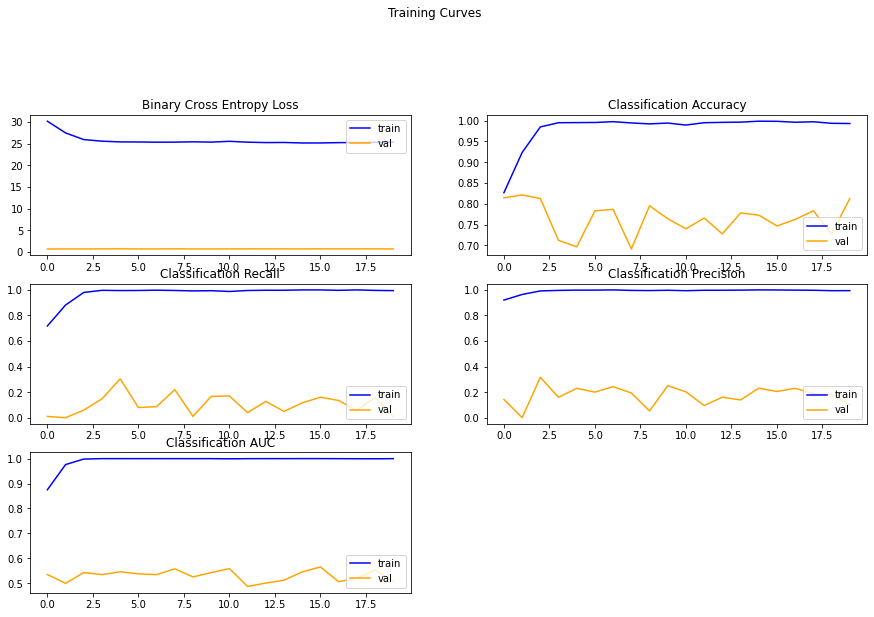

In [ ]:
threshold = 0.5
new_model_2 = train_1st_model(x_train, y_train, x_val, y_val)

## Save and download model

In [ ]:
tf.keras.models.save_model(new_model_2, "/content/model3")

INFO:tensorflow:Assets written to: /content/model3/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
!zip -r /content/hcqt_heavy_shallow_EPFL.zip /content/model3

  adding: content/model3/ (stored 0%)
  adding: content/model3/variables/ (stored 0%)
  adding: content/model3/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model3/variables/variables.index (deflated 80%)
  adding: content/model3/assets/ (stored 0%)
  adding: content/model3/saved_model.pb (deflated 92%)
  adding: content/model3/keras_metadata.pb (deflated 96%)


# 2nd training of the model with Cambridge Dataset-2 ensemble models

In [ ]:
!unzip "/content/hcqt_heavy_shallow_EPFL.zip" -d "model_8"

Archive:  /content/hcqt_heavy_shallow_EPFL.zip
   creating: model_8/content/model3/
   creating: model_8/content/model3/variables/
  inflating: model_8/content/model3/variables/variables.data-00000-of-00001  
  inflating: model_8/content/model3/variables/variables.index  
   creating: model_8/content/model3/assets/
  inflating: model_8/content/model3/saved_model.pb  
  inflating: model_8/content/model3/keras_metadata.pb  


In [ ]:
%cd ../../content

/content


## Initialize training

In [ ]:
transform_name = 'hcqt'
dataset = 'Cambridge' # 'Coswara_full', 'Coswara_cough-heavy', 'Coswara_cough-shallow', 'EPFL', 'EPFL_small'
batch_size = 32

## Prepare data

In [ ]:
csv_path = 'Cambridge_labels.csv' # path to labels csv

labels_dict_cambridge = {}
with open(csv_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      if row[1] == 'neg':
        labels_dict_cambridge[row[0]] = [0.0]
      elif row[1] == 'pos':
        labels_dict_cambridge[row[0]] = [1.0]

In [ ]:
image_path = "Cambridge/Cambridge/" + transform_name + "/" # path to folder containing images

input_arr_cambridge = []
labels_arr_cambridge = []
names_arr_cambridge = []

for i in os.listdir(image_path):
  if i in labels_dict_cambridge.keys():
    image = tf.keras.preprocessing.image.load_img(image_path + i, color_mode = 'rgb', target_size = (32,32,3))
    labels_arr_cambridge.append(labels_dict_cambridge[i])
    input_arr_cambridge.append(tf.keras.preprocessing.image.img_to_array(image))
    names_arr_cambridge.append(i)

In [ ]:
input_arr_cambridge = np.array(input_arr_cambridge)
labels_arr_cambridge = np.array(labels_arr_cambridge)

In [ ]:
tmp = list(zip(input_arr_cambridge, labels_arr_cambridge, names_arr_cambridge))

random.Random(32).shuffle(tmp)

input_arr_cambridge, labels_arr_cambridge, names_arr_cambridge = zip(*tmp)
input_arr_cambridge = np.array(input_arr_cambridge)
labels_arr_cambridge = np.array(labels_arr_cambridge)

In [ ]:
data_size, img_rows, img_cols, img_channels = input_arr_cambridge.shape

In [ ]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 32
IMG_SHAPE = (img_rows, img_cols, img_channels)
threshold = 0.5
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

## Functions used during training and testing

In [ ]:
def train_model(model, train_ds, validation_ds, weights, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps, class_weight = weights)
  return(history)

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  plt.figure(figsize=(15, 15))
  plt.suptitle('Training Curves')
  # plot loss
  
  plt.subplot(521)
  plt.title('Binary Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
  plt.legend(loc='upper right')
  # plot accuracy
  plt.subplot(522)
  plt.title('Classification Accuracy')
  plt.plot(history.history['Accuracy'], color='blue', label='train')
  plt.plot(history.history['val_Accuracy'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(523)
  plt.title('Classification Recall')
  plt.plot(history.history['Recall'], color='blue', label='train')
  plt.plot(history.history['val_Recall'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(524)
  plt.title('Classification Precision')
  plt.plot(history.history['Precision'], color='blue', label='train')
  plt.plot(history.history['val_Precision'], color='orange', label='val')
  plt.legend(loc='lower right')
  plt.subplot(525)
  plt.title('Classification AUC')
  plt.plot(history.history['AUC'], color='blue', label='train')
  plt.plot(history.history['val_AUC'], color='orange', label='val')
  plt.legend(loc='lower right')
  return plt

In [ ]:
def evaluate_trained_model(x_test, y_test, new_model, steps_per_epoch = 10):
    loss, recall, precision, auc, acc, tp, fp, fn, tn = new_model.evaluate(x_test, y_test, steps = steps_per_epoch)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print('Restored model, recall: {:5.2f}%'.format(100 * recall))
    print('Restored model, precision: {:5.2f}%'.format(100 * precision))
    print('Restored model, Specificity: ', (tn/(tn+fp))*100)
    print('Restored model, AUC: {:5.2f}%'.format(100 * auc))
    
    print('Restored model, true positives: ', tp)
    print('Restored model, false positives: ', fp)
    print('Restored model, false negatives: ', fn)
    print('Restored model, true negatives: ', tn)
    
    return recall, precision, auc, acc, tp, fp, fn, tn

In [ ]:
def get_predictions(model, x_test, y_test, threshold, steps_per_epoch):
    pred=model.predict(x_test, steps = steps_per_epoch)
    
    probabilities = []
    predictions = []
    for i in pred:
        if i[0] >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
    for i in pred:
        probabilities.append(i[0])
    
    return probabilities, predictions, pred

In [ ]:
def print_average_results(probabilities_list, y_test, threshold):
    probabilities = calculate_mean_probabilities(probabilities_list)
    predictions = get_total_predictions(probabilities, threshold)
    (acc, recall, precision, auc, specificity)  = calculate_metrics(predictions, probabilities, y_test, threshold)
    tpr, fpr, thresholds = plot_roc(y_test, probabilities)
    return (acc, recall, precision, auc, specificity)  


def calculate_mean_probabilities(probabilities_list):
  probabilities = []
  
  for i in range(len(probabilities_list[0])):
    mean_probability = np.mean([probabilities_list[0][i], probabilities_list[1][i]])
    probabilities.append([mean_probability])
  
  probabilities = np.array(probabilities)
  return probabilities

def get_total_predictions(probabilities, threshold):
  predictions = []
  for i in probabilities:
    if i[0] >= threshold:
      predictions.append(1.0)
    elif i[0] < threshold:
      predictions.append(0.0)
  
  predictions = np.array(predictions)
  return predictions

def calculate_metrics(predictions, probabilities, y_test, threshold):
  acc = accuracy_score(y_test, predictions)*100
  recall = recall_score(y_test, predictions, zero_division = 0)*100
  precision  = precision_score(y_test, predictions, zero_division = 0)*100
  auc = roc_auc_score(y_test, probabilities)*100
  tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
  specificity = tn / (tn+fp)
  print("Accuracy: ", acc, "%")
  print("Recall: ", recall, "%")
  print("Precision: ",precision, "%")
  print("AUC: ",auc, "%")
  print("Specificity: ", specificity*100, "%")

  return (acc, recall, precision, auc, specificity*100)          

In [ ]:
# Plot ROC curve

def plot_roc(y_true, probabilities):
    y_true_int = []
    for i in y_true:
        y_true_int.append(int(i))

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_true_int, probabilities)
    # plot the roc curve for the model
    plt.subplot(526)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='CNN Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    print(roc_auc_score(y_true_int, probabilities), "AUC")
    return tpr, fpr, thresholds

In [ ]:
def calculate_weights(y_train):
    no_neg = 0
    no_pos = 0
    for i in y_train:
        if i[0] == 0.0:
            no_neg = no_neg + 1
        else:
            no_pos = no_pos + 1
    print("Train set in use: Number of negatives:", no_neg, "|| Number of positives:", no_pos)

    ratio = (no_pos*100)/(no_neg+no_pos)
    w_0 = ratio
    w_1 = 100-ratio
    print("w_0:", w_0)
    print("w_1:", w_1)

    # Give class weights
    class_weight = {0: w_0,
                    1: w_1}
    return class_weight

In [ ]:
def _input_fn(x, y, BATCH_SIZE, data_size, IMG_SIZE): ### to data size prostethike meta

  x_reshaped = []
  print(x.shape)
  for i in x:
    x_reshaped.append(tf.image.resize(i, IMG_SIZE))
  x_reshaped = np.array(x_reshaped)
  print(x_reshaped.shape)
  ds = tf.data.Dataset.from_tensor_slices((x_reshaped,y)) 
  ds = ds.shuffle(buffer_size=data_size) # https://datascience.stackexchange.com/questions/89316/tensorflows-shufflebuffer-size
  ds = ds.repeat() # https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
def ensemble_split(x_train, y_train):
  neg = 0
  pos = 0

  x_train_set = []
  y_train_set = []

  tmp_1x = []
  tmp_2x = []

  tmp_1y = []
  tmp_2y = []

  tmp_x = []
  tmp_y = []
  
  for i in y_train:
    if i[0] == 0.0:
      neg = neg + 1
    else:
      pos = pos + 1

  print("Initial train set contains", pos, "covid samples and", neg, "non-covid samples")
  neg_samples = round(neg/2)

  train_neg = []
  train_pos = []
  index = 0

  for i in y_train:
    if i[0] == 0.0:
      train_neg.append(index)
    elif i[0] == 1.0:
      train_pos.append(index)
    index = index + 1
  
  index_1 = train_neg[0:neg_samples]
  index_2 = train_neg[neg_samples:]

  for i in index_1:
    tmp_1x.append(x_train[i])
    tmp_1y.append(y_train[i])

  for i in index_2:
    tmp_2x.append(x_train[i])
    tmp_2y.append(y_train[i])
  
  for i in train_pos:
    tmp_x.append(x_train[i])
    tmp_y.append(y_train[i])

  tmp_x = np.array(tmp_x)
  tmp_y  = np.array(tmp_y)

  tmp_1x = np.array(tmp_1x)
  tmp_2x = np.array(tmp_2x)

  tmp_1y = np.array(tmp_1y)
  tmp_2y = np.array(tmp_2y)

  x_train_set.append(np.concatenate((tmp_1x,tmp_x), axis = 0))
  x_train_set.append(np.concatenate((tmp_2x,tmp_x), axis = 0))

  y_train_set.append(np.concatenate((tmp_1y,tmp_y), axis = 0))
  y_train_set.append(np.concatenate((tmp_2y,tmp_y), axis = 0))

  return x_train_set, y_train_set

In [ ]:
def train_with_5_folds_ensemble(splitted_folds):
  PROBABILITIES_LIST = []
  PREDICTIONS_LIST = []
  ACCURACY = []
  RECALL = []
  PRECISION = []
  AUC = []
  SPECIFICITY = []
  PREDICTIONS = []
  ACTUAL = []
  new_m = []
  j = 0
  for fold in splitted_folds:

    X_train = []
    X_val = []
    X_test = []

    y_train = []
    y_val = []
    y_test = []


    for files in fold[0]:
      X_train.append(input_arr_cambridge[files]/255.0)
      y_train.append(labels_arr_cambridge[files])
    for files in fold[1]:
      X_val.append(input_arr_cambridge[files]/255.0)
      y_val.append(labels_arr_cambridge[files])
    for files in fold[2]:
      X_test.append(input_arr_cambridge[files]/255.0)
      y_test.append(labels_arr_cambridge[files])


    print("Initial train set", len(X_train), len(y_train))
    print("Initial validation set", len(X_val), len(y_val))
    print("Initial test set", len(X_test), len(y_test))
    
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)

    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)

    neg = 0 
    pos = 0
    for i in y_test:
      if i[0] == 1.0:
        pos = pos + 1
      elif i[0] == 0.0:
        neg = neg + 1

    print("Initial test set: Negative samples:", neg, "|| Positive samples:", pos, "|| Total_samples:", neg+pos) 

    neg = 0 
    pos = 0
    for i in y_val:
      if i[0] == 1.0:
        pos = pos + 1
      elif i[0] == 0.0:
        neg = neg + 1

    print("Initial validation set: Negative samples:", neg, "|| Positive samples:", pos, "|| Total_samples:", neg+pos)

    (PRED, test, acc, recall, precision, auc, specificity, m) = train_with_ensemble(X_train, y_train, X_val, y_val, X_test, y_test)
    new_m.append(m)
    j = j + 1

    RECALL.append(recall)
    PRECISION.append(precision)
    AUC.append(auc)
    ACCURACY.append(acc)
    SPECIFICITY.append(specificity)
    PREDICTIONS.append(PRED)
    ACTUAL.append(test)


  print("Accuracy:", round(np.mean(ACCURACY),4), "%")
  print("Recall:", round(np.mean(RECALL),4), "%")
  print("Precision:", round(np.mean(PRECISION),4), "%")
  print("AUC:", round(np.mean(AUC),4), "%")
  print("Specificity:", round(np.mean(SPECIFICITY),4), "%")
  return PREDICTIONS, ACTUAL, new_m

In [ ]:
def train_with_ensemble(X_train, y_train, X_val, y_val, X_test, y_test):
    img = 100

    IMG_SHAPE = (img, img, 3)
    new_models = []
    validation_ds =_input_fn(X_val,y_val, BATCH_SIZE, data_size, (img,img)) #PrefetchDataset object

    test_ds =_input_fn(X_test, y_test, BATCH_SIZE, data_size, (img,img)) #PrefetchDataset object

    x_train_set, y_train_set = ensemble_split(X_train, y_train)

    x_reshaped = []
    for i in X_test:
      x_reshaped.append(tf.image.resize(i, (img, img)))
    x_reshaped = np.array(x_reshaped)

    PROBABILITIES_LIST = []
    PREDICTIONS_LIST = []
    for i in range(len(x_train_set)):
      weights = calculate_weights(y_train_set[i])

      test_steps = int(len(y_test)/BATCH_SIZE)
      train_ds =_input_fn(x_train_set[i], y_train_set[i], BATCH_SIZE, data_size, (img,img))
      
    
      new_model1 = keras.models.load_model('model_8/content/model3') # path to saved model

      model_history = train_model(new_model1, train_ds, validation_ds, weights, 25, int(len(y_train)/BATCH_SIZE), 10)
    
      summarize_diagnostics(model_history)

      recall, precision, auc, acc, tp, fp, fn, tn = evaluate_trained_model(x_reshaped, y_test, new_model1, steps_per_epoch = test_steps)
      
      probabilities, predictions, pred = get_predictions(new_model1, x_reshaped, y_test, threshold, test_steps)

      PROBABILITIES_LIST.append(probabilities)
      PREDICTIONS_LIST.append(predictions)
      new_models.append(new_model1)
      
    (acc, recall, precision, auc, specificity) = print_average_results(PROBABILITIES_LIST, y_test, threshold)
    print()

    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------------------------------------------")
    return (PROBABILITIES_LIST, y_test, acc, recall, precision, auc,specificity, new_models)  

In [ ]:
def folds_split_Cambridge_stratified():
  folds_split = 0.2

  folds = [[], [], [], [], []]

  ###folds contain indices
  ind_flag = [0] * len(names_arr_cambridge)

  cnt = 0 
  x = folds_split

  non_covid = 0
  covid = 0

  for file in labels_arr_cambridge:
    if file == [0.0]:
      non_covid = non_covid + 1
    else:
      covid = covid + 1

  non_covid_percentage = non_covid/(covid + non_covid)
  covid_percentage = covid/(covid + non_covid)

  print("Non covid percentage:", non_covid_percentage)
  print("Covid percentage:", covid_percentage)


  for i in range(5):
    neg = 0
    pos = 0
    while len(folds[i]) < folds_split*data_size :
      for ind in range(data_size):
        if ind_flag[ind] == 0:
          if len(names_arr_cambridge[ind].split("_")) ==  3: # ---> android files' format (only android files have many samples from the same user)
            indices = [j for j, s in enumerate(names_arr_cambridge) if names_arr_cambridge[ind].split(".")[0].split("_")[1] in s]
            if i!=4 and (labels_arr_cambridge[ind] == [0.0] and neg<=non_covid_percentage*folds_split*data_size) or (labels_arr_cambridge[ind] == [1.0] and pos<=covid_percentage*folds_split*data_size):
              for inds in indices:
                
                if labels_arr_cambridge[inds] == [0.0]:
                  neg = neg + 1
                else:
                  pos = pos + 1
                
                folds[i].append(inds)
                ind_flag[inds] = 1
              cnt = cnt + len(indices)
            elif i==4 :
              for inds in indices:
                
                if labels_arr_cambridge[inds] == [0.0]:
                  neg = neg + 1
                else:
                  pos = pos + 1
                
                folds[i].append(inds)
                ind_flag[inds] = 1
              cnt = cnt + len(indices)

            else:
              continue
          else:
            
            indices = [j for j, s in enumerate(names_arr_cambridge) if names_arr_cambridge[ind].split(".")[0].split("_")[1] + "_" + names_arr_cambridge[ind].split(".")[0].split("_")[2] + "_" + names_arr_cambridge[ind].split(".")[0].split("_")[3] + "_" + names_arr_cambridge[ind].split(".")[0].split("_")[4] in s]
            
            if i!=4 and (labels_arr_cambridge[ind] == [0.0] and neg<=non_covid_percentage*folds_split*data_size) or (labels_arr_cambridge[ind] == [1.0] and pos<=covid_percentage*folds_split*data_size):
              for inds in indices:
                
                if labels_arr_cambridge[inds] == [0.0]:
                  neg = neg + 1
                else:
                  pos = pos + 1
                folds[i].append(inds)
                ind_flag[inds] = 1
              cnt = cnt + len(indices)
            elif i==4:
              
              for inds in indices:
                
                if labels_arr_cambridge[inds] == [0.0]:
                  neg = neg + 1
                else:
                  pos = pos + 1
                folds[i].append(inds)
                ind_flag[inds] = 1
              cnt = cnt + len(indices)
            else:
              continue

        if len(folds[i]) >= folds_split*data_size:
          break
      if i == 4 and cnt == data_size:
        break
    
  return folds

## Training and testing

In [ ]:
folds = folds_split_Cambridge_stratified()

Non covid percentage: 0.69
Covid percentage: 0.31


In [ ]:
# statistics for each fold
for f in folds:
  neg = 0
  pos = 0
  for ff in f:
    if labels_arr_cambridge[ff] == [0.0]:
      neg = neg + 1
    else:
      pos =pos + 1
  print("Negative:", neg/(neg+pos), "positive:", pos/(neg+pos))
  print("--------------------------------------------------------")

Negative: 0.7023809523809523 positive: 0.2976190476190476
--------------------------------------------------------
Negative: 0.691358024691358 positive: 0.30864197530864196
--------------------------------------------------------
Negative: 0.65 positive: 0.35
--------------------------------------------------------
Negative: 0.6625 positive: 0.3375
--------------------------------------------------------
Negative: 0.7466666666666667 positive: 0.25333333333333335
--------------------------------------------------------


In [ ]:
# statistics for each fold
cnt = 0
fold_dict = {}
for f in folds:
  freq = {}
  web = 0
  android = 0
  print("Fold: ", cnt)
  neg = 0
  pos = 0
  for i in f:
    if names_arr_cambridge[i].split("_")[1].split("-")[0]!='2020':
      freq[names_arr_cambridge[i].split("_")[1]] = 0
      android = android +1
    else:
      freq[names_arr_cambridge[i]] = 0
      web = web + 1
  for i in f:
      if names_arr_cambridge[i].split("_")[1].split("-")[0]!='2020':
        tmp = freq[names_arr_cambridge[i].split("_")[1]]
        freq[names_arr_cambridge[i].split("_")[1]] = tmp + 1
      else:
        freq[names_arr_cambridge[i]] = 1
      if labels_arr_cambridge[i] == [0.]:
        neg = neg + 1
      else:
        pos = pos + 1

  print("Total number of users:", len(freq.keys()))
  print("Total negative samples:", neg, "(", round((neg*100)/(neg+pos), 3 ), "% )")
  print("Total positive samples:", pos, "(", round((pos*100)/(neg+pos), 3), "% )")
  print("Web samples:", web, "(", round(web*100/(web+android),3), "% )")
  print("Android samples:", android,  "(", round(android*100/(web+android),3), "% )")
  fold_dict[cnt] = (len(freq.keys()), neg, pos)
  print("_____________________________________________________________________________________________________")
  cnt = cnt + 1
print(fold_dict)

Fold:  0
Total number of users: 26
Total negative samples: 59 ( 70.238 % )
Total positive samples: 25 ( 29.762 % )
Web samples: 11 ( 13.095 % )
Android samples: 73 ( 86.905 % )
_____________________________________________________________________________________________________
Fold:  1
Total number of users: 49
Total negative samples: 56 ( 69.136 % )
Total positive samples: 25 ( 30.864 % )
Web samples: 32 ( 39.506 % )
Android samples: 49 ( 60.494 % )
_____________________________________________________________________________________________________
Fold:  2
Total number of users: 63
Total negative samples: 52 ( 65.0 % )
Total positive samples: 28 ( 35.0 % )
Web samples: 46 ( 57.5 % )
Android samples: 34 ( 42.5 % )
_____________________________________________________________________________________________________
Fold:  3
Total number of users: 71
Total negative samples: 53 ( 66.25 % )
Total positive samples: 27 ( 33.75 % )
Web samples: 49 ( 61.25 % )
Android samples: 31 ( 38.75 % 

In [ ]:
for f in folds[0]:
  if f in folds[1] or f in folds[2] or f in folds[3] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[1]:
  if f in folds[0] or f in folds[2] or f in folds[3] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[2]:
  if f in folds[0] or f in folds[1] or f in folds[3] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[3]:
  if f in folds[0] or f in folds[1] or f in folds[2] or f in folds[4]:
    print("The same sample exists in more than one folds")

for f in folds[4]:
  if f in folds[0] or f in folds[1] or f in folds[2] or f in folds[3]:
    print("The same sample exists in more than one folds")

In [ ]:
# concatenate folds to create 5 different splits of the dataset into train, validation and test set

tmp = []
splitted_folds = []
for i in range(len(folds)):
  print(len(folds[i]))

tmp.append(list(folds[1]+folds[2]+folds[3])) # train
tmp.append(folds[4]) # validation
tmp.append(list(folds[0])) # test
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[0]+folds[2]+folds[4]))
tmp.append(folds[3])
tmp.append(list(folds[1]))
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[0]+folds[3]+folds[4]))
tmp.append(folds[1])
tmp.append(list(folds[2]))
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[1]+folds[2]+folds[4]))
tmp.append(folds[0])
tmp.append(list(folds[3]))
splitted_folds.append(list(tmp))
tmp = []

tmp.append(list(folds[0]+folds[1]+folds[3]))
tmp.append(folds[2])
tmp.append(list(folds[4]))
splitted_folds.append(list(tmp))

84
81
80
80
75


In [ ]:
for f in splitted_folds:
  print("Train set contains", len(f[0]), "samples, validation set contains", len(f[1]), "samples, test set contains", len(f[2]), "samples")

Train set contains 241 samples, validation set contains 75 samples, test set contains 84 samples
Train set contains 239 samples, validation set contains 80 samples, test set contains 81 samples
Train set contains 239 samples, validation set contains 81 samples, test set contains 80 samples
Train set contains 236 samples, validation set contains 84 samples, test set contains 80 samples
Train set contains 245 samples, validation set contains 80 samples, test set contains 75 samples


In [ ]:
# statistics for each fold
for ff in folds:
  neg = 0
  pos = 0
  for i in ff:
    if labels_arr_cambridge[i] == [0.0]:
      neg = neg + 1
    else:
      pos = pos + 1
  print("Negative:", neg, "total", pos+neg, "Percentage:", (neg*100)/(neg+pos))
  print("Positive:", pos, "total", pos+neg, "Percentage:", (pos*100)/(neg+pos))
  print("-------------------------------------------------------------------------")

Negative: 59 total 84 Percentage: 70.23809523809524
Positive: 25 total 84 Percentage: 29.761904761904763
-------------------------------------------------------------------------
Negative: 56 total 81 Percentage: 69.1358024691358
Positive: 25 total 81 Percentage: 30.864197530864196
-------------------------------------------------------------------------
Negative: 52 total 80 Percentage: 65.0
Positive: 28 total 80 Percentage: 35.0
-------------------------------------------------------------------------
Negative: 53 total 80 Percentage: 66.25
Positive: 27 total 80 Percentage: 33.75
-------------------------------------------------------------------------
Negative: 56 total 75 Percentage: 74.66666666666667
Positive: 19 total 75 Percentage: 25.333333333333332
-------------------------------------------------------------------------


##Train and test model

Initial train set 241 241
Initial validation set 75 75
Initial test set 84 84
Initial test set: Negative samples: 59 || Positive samples: 25 || Total_samples: 84
Initial validation set: Negative samples: 56 || Positive samples: 19 || Total_samples: 75
(75, 32, 32, 3)
(75, 100, 100, 3)
(84, 32, 32, 3)
(84, 100, 100, 3)
Initial train set contains 80 covid samples and 161 non-covid samples
Train set in use: Number of negatives: 80 || Number of positives: 80
w_0: 50.0
w_1: 50.0
(160, 32, 32, 3)
(160, 100, 100, 3)
Epoch 1/25
7/7 [==============================] - 17s 685ms/step - loss: 33.7093 - Recall: 0.6552 - Precision: 0.6726 - AUC: 0.7263 - Accuracy: 0.6562 - true_positives: 76.0000 - false_positives: 37.0000 - false_negatives: 40.0000 - true_negatives: 71.0000 - val_loss: 0.6889 - val_Recall: 0.0482 - val_Precision: 1.0000 - val_AUC: 0.4932 - val_Accuracy: 0.7531 - val_true_positives: 4.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 79.0000 - val_true_negatives: 237.000

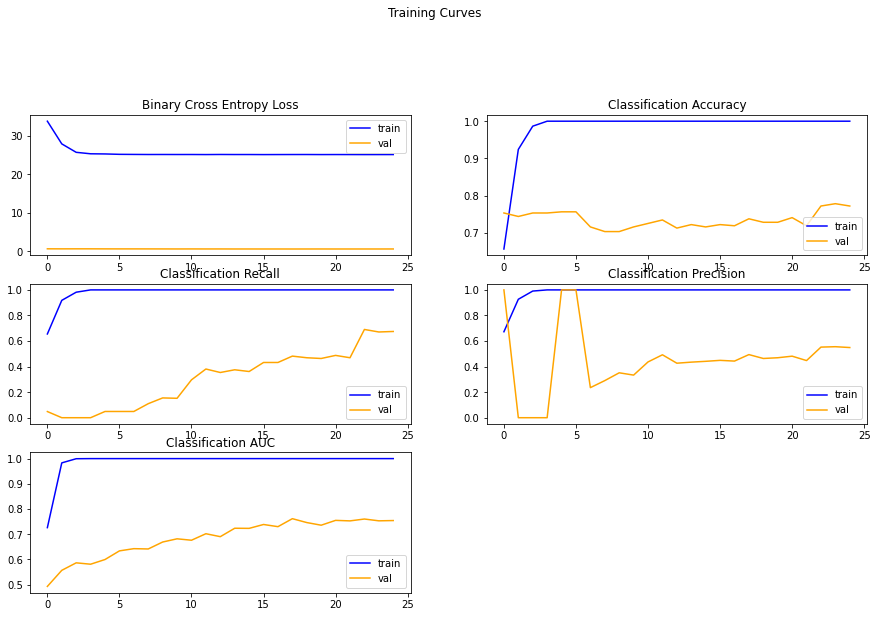

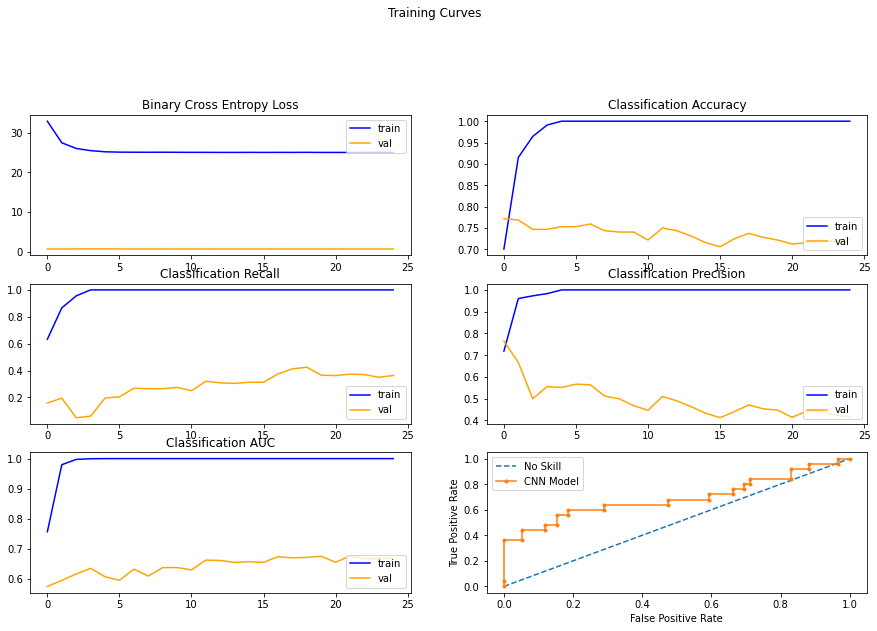

0.6942372881355933 AUC

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 239 239
Initial validation set 80 80
Initial test set 81 81
Initial test set: Negative samples: 56 || Positive samples: 25 || Total_samples: 81
Initial validation set: Negative samples: 53 || Positive samples: 27 || Total_samples: 80
(80, 32, 32, 3)
(80, 100, 100, 3)
(81, 32, 32, 3)
(81, 100, 100, 3)
Initial train set contains 72 covid samples and 167 non-covid samples
Train set in use: Number of negatives: 84 || Number of positives: 72
w_0: 46.15384615384615
w_1: 53.84615384615385
(156, 32, 32, 3)
(156, 100, 100, 3)
Epoch 1/25
7/7 [==============================] - 12s 683ms/step - loss: 33.3682 - Recall: 0.5588 - Precision: 0.6404 - AUC: 0.7117 - Accuracy: 0.6562 - tr

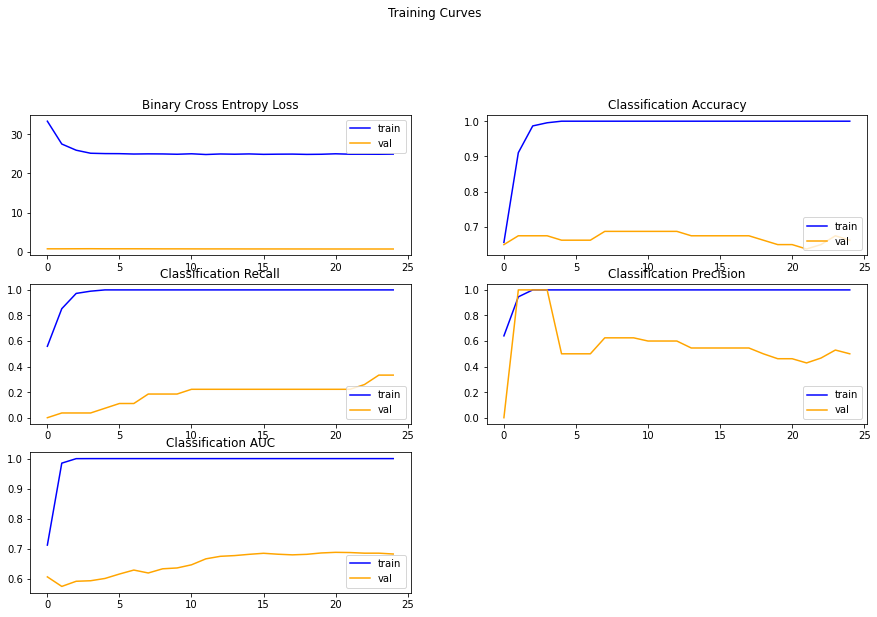

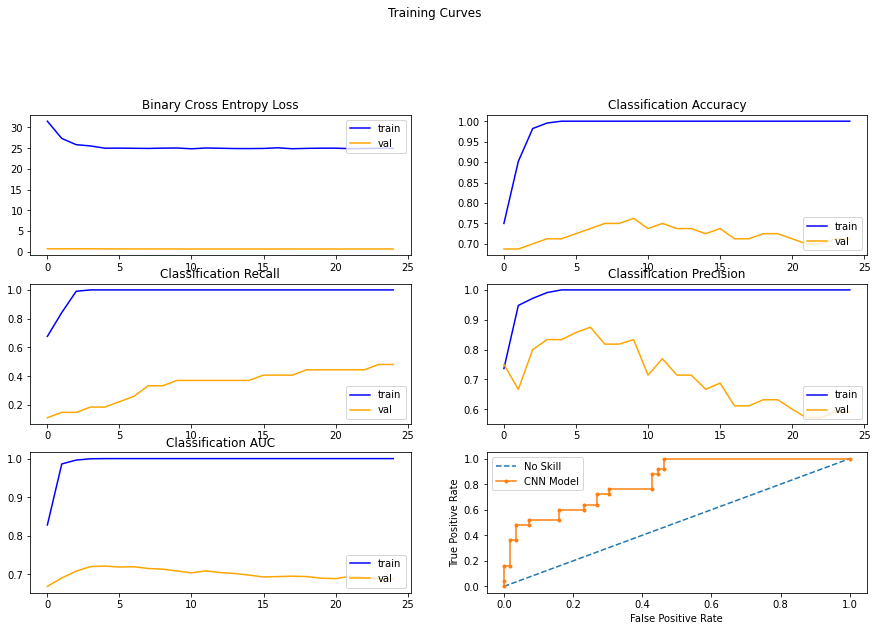

0.8271428571428571 AUC

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 239 239
Initial validation set 81 81
Initial test set 80 80
Initial test set: Negative samples: 52 || Positive samples: 28 || Total_samples: 80
Initial validation set: Negative samples: 56 || Positive samples: 25 || Total_samples: 81
(81, 32, 32, 3)
(81, 100, 100, 3)
(80, 32, 32, 3)
(80, 100, 100, 3)
Initial train set contains 71 covid samples and 168 non-covid samples
Train set in use: Number of negatives: 84 || Number of positives: 71
w_0: 45.806451612903224
w_1: 54.193548387096776
(155, 32, 32, 3)
(155, 100, 100, 3)
Epoch 1/25
7/7 [==============================] - 12s 685ms/step - loss: 34.6561 - Recall: 0.4653 - Precision: 0.5595 - AUC: 0.6230 - Accuracy: 0.5938 - 

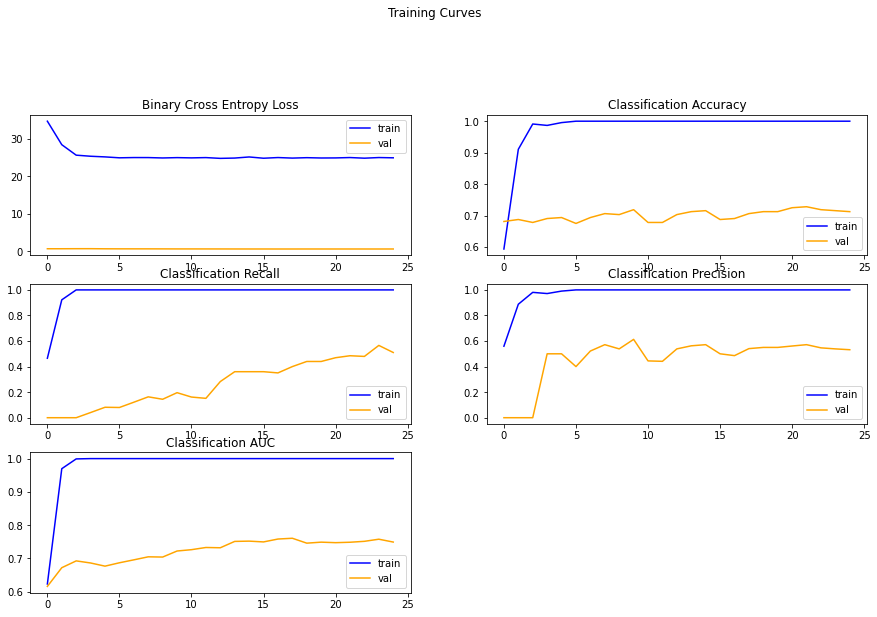

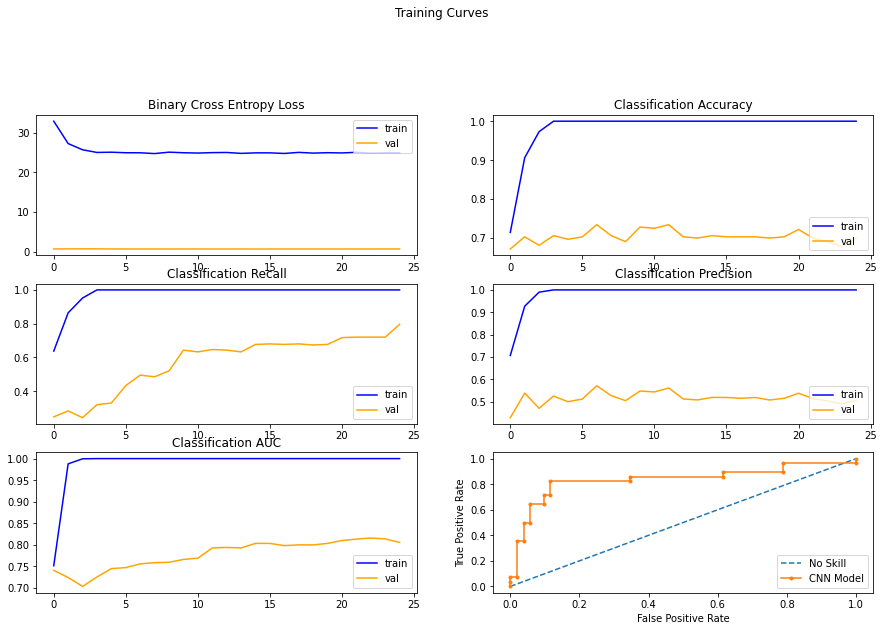

0.8351648351648352 AUC

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 236 236
Initial validation set 84 84
Initial test set 80 80
Initial test set: Negative samples: 53 || Positive samples: 27 || Total_samples: 80
Initial validation set: Negative samples: 59 || Positive samples: 25 || Total_samples: 84
(84, 32, 32, 3)
(84, 100, 100, 3)
(80, 32, 32, 3)
(80, 100, 100, 3)
Initial train set contains 72 covid samples and 164 non-covid samples
Train set in use: Number of negatives: 82 || Number of positives: 72
w_0: 46.753246753246756
w_1: 53.246753246753244
(154, 32, 32, 3)
(154, 100, 100, 3)
Epoch 1/25
7/7 [==============================] - 12s 679ms/step - loss: 32.2824 - Recall: 0.6606 - Precision: 0.7347 - AUC: 0.8002 - Accuracy: 0.7188 - 

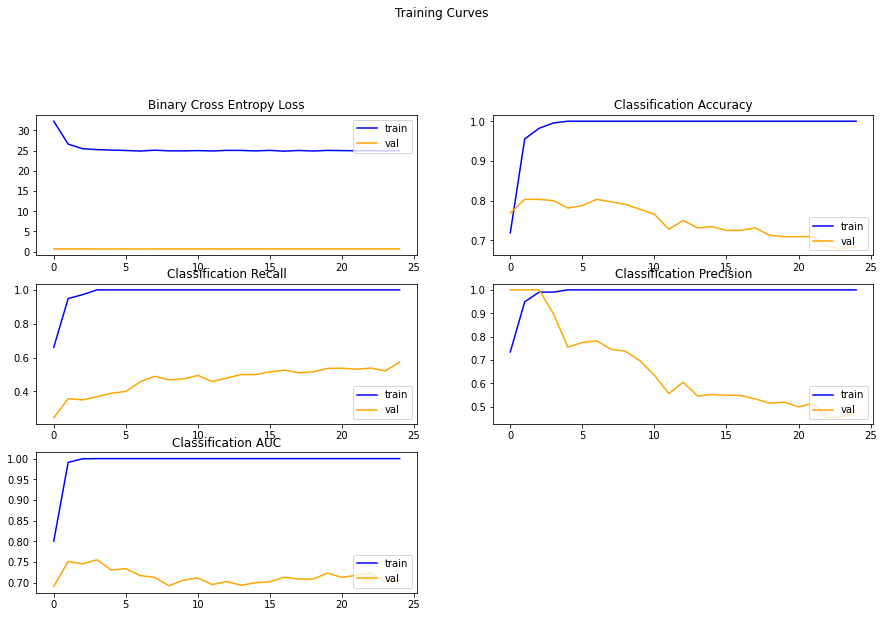

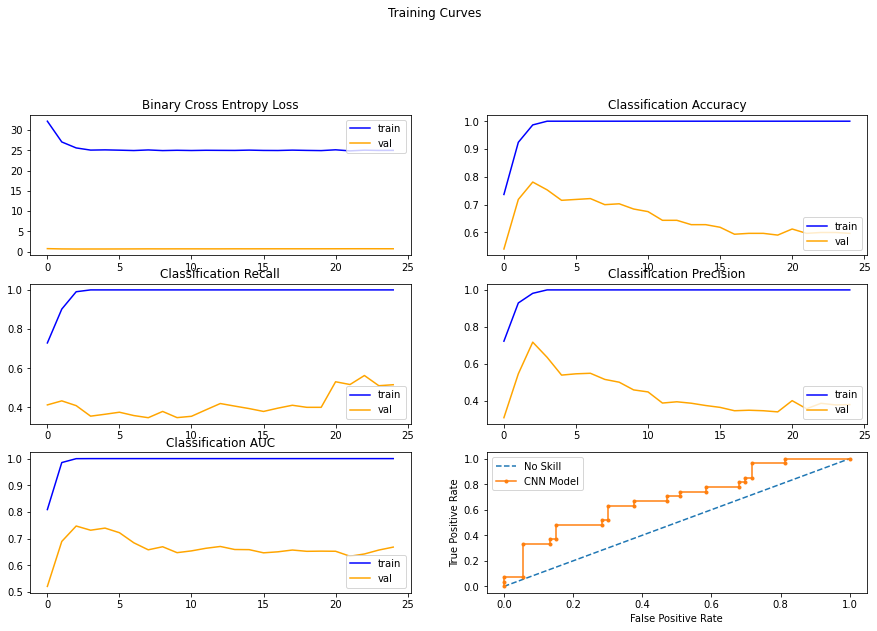

0.686932215234102 AUC

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Initial train set 245 245
Initial validation set 80 80
Initial test set 75 75
Initial test set: Negative samples: 56 || Positive samples: 19 || Total_samples: 75
Initial validation set: Negative samples: 52 || Positive samples: 28 || Total_samples: 80
(80, 32, 32, 3)
(80, 100, 100, 3)
(75, 32, 32, 3)
(75, 100, 100, 3)
Initial train set contains 77 covid samples and 168 non-covid samples
Train set in use: Number of negatives: 84 || Number of positives: 77
w_0: 47.82608695652174
w_1: 52.17391304347826
(161, 32, 32, 3)
(161, 100, 100, 3)
Epoch 1/25
7/7 [==============================] - 12s 679ms/step - loss: 34.5788 - Recall: 0.5234 - Precision: 0.6222 - AUC: 0.6411 - Accuracy: 0.6205 - tru

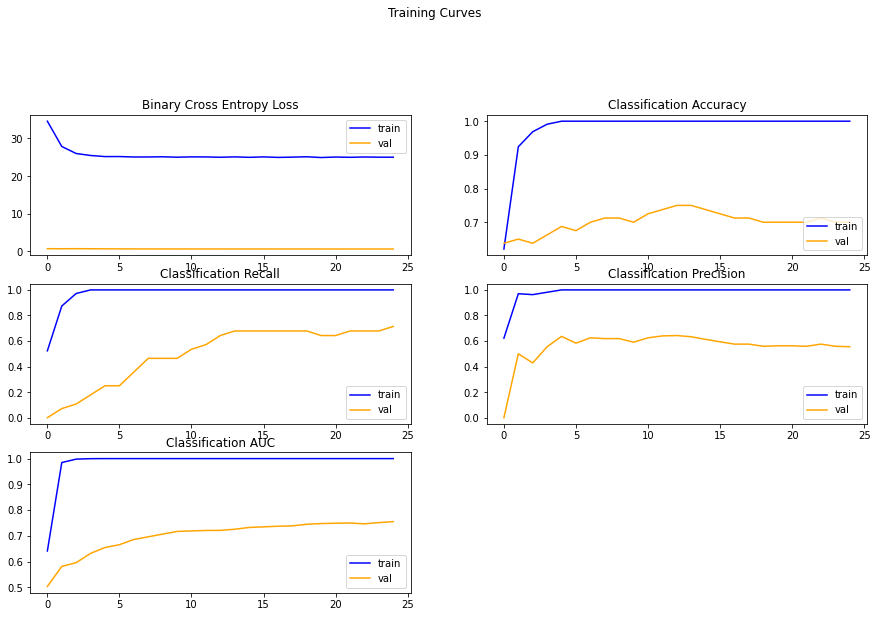

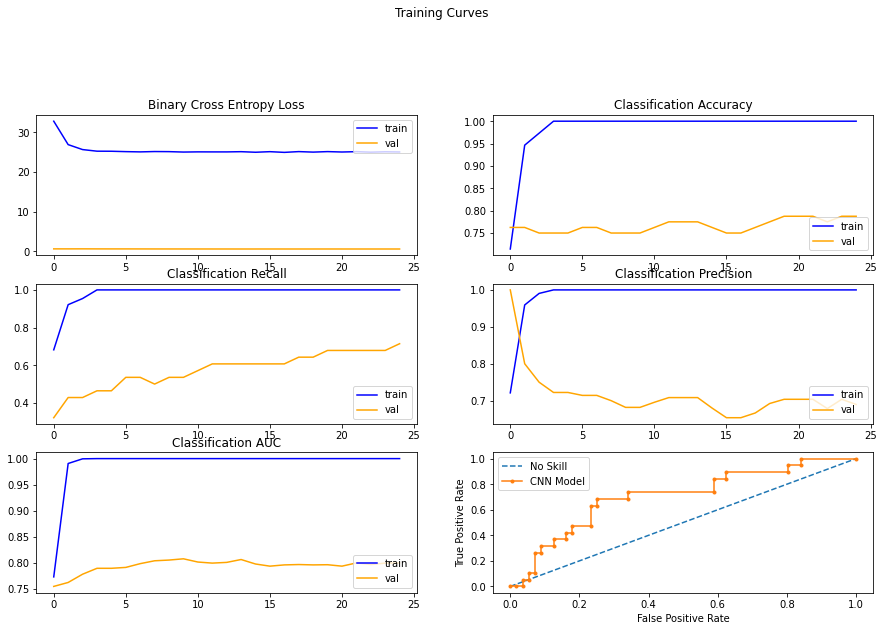

0.7058270676691729 AUC

-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Accuracy: 71.855 %
Recall: 56.8044 %
Precision: 54.2509 %
AUC: 74.9861 %
Specificity: 78.3054 %


In [ ]:
threshold = 0.5
PRED, ACTUAL, models = train_with_5_folds_ensemble(splitted_folds)

## Hosmer-Lemeshow test
`data.json` files contain predicted and actual values for each sample of the test set, for each one of the five different splits of the dataset resulting from the 5-fold cross validation. These values are given as input to the following R code, to calculate the Hosmer-Lemeshow test statistic of the model.


```
library(ResourceSelection)
hl <- hoslem.test(x, y, g=10)
hl          
```

where x contains the predicted values and y the actual values of one of the 5 iterations

In [ ]:
y_pred = []
for i in ACTUAL:
  preds = []
  for j in i:
    preds.append(j[0])
  y_pred.append(preds)

In [ ]:
prs = []
for j in range(5):
  tmp2 = []
  tmp1 = calculate_mean_probabilities(PRED[j])
  pr = get_total_predictions(tmp1, 0.5)
  prs.append(list(pr))

In [ ]:
mydict = {"Predicted": prs[0], "Actual": y_pred[0]}
with open('data1.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[1], "Actual": y_pred[1]}
with open('data2.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[2], "Actual": y_pred[2]}
with open('data3.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[3], "Actual": y_pred[3]}
with open('data4.json', 'w') as fp:
    json.dump(str(mydict), fp)
mydict = {"Predicted": prs[4], "Actual": y_pred[4]}
with open('data5.json', 'w') as fp:
    json.dump(str(mydict), fp)